<a href="https://colab.research.google.com/github/kjedrzejczak/Wprowadzenie_do_sieci_neuronowych-Tensorflow_2.0-Keras/blob/main/24_Model_transfer_learning_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

np.set_printoptions(precision=6, suppress=True)

# pobieranie danych

In [2]:
!wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
!unzip -q flying-vehicles.zip

# Przygotowanie danych

In [3]:
!rm -rf ./images  # czyszczenie katalogu roboczego

In [4]:
"""👉Sprawdzanie ilości zdjęc dla danej klasy👈"""
base_dir = './data/planes'
row_no_of_files = {}
classes = ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']
for i in classes:
  row_no_of_files[i] = len(os.listdir(os.path.join(base_dir, i)))


row_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [5]:
"""👉tworzymy katalog "images" -> "train" -> ['drone', 'passenger']👈"""

data_dir = './images'

if not os.path.exists(data_dir):   # katalog główny "images"
  os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')   # podkatalog dane treningowe
valid_dir = os.path.join(data_dir, 'valid')   # podkatalog dane treningowe
test_dir = os.path.join(data_dir, 'test')     # podkatalog dane treningowe


train_drone_dir = os.path.join(train_dir, 'drone')
valid_drone_dir = os.path.join(valid_dir, 'drone')
test_drone_dir = os.path.join(test_dir, 'drone')


train_passenger_dir = os.path.join(train_dir, 'passenger')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')
test_passenger_dir = os.path.join(test_dir, 'passenger')

"""tworzenie katalogów"""
for i in (train_dir, valid_dir, test_dir):
  if not os.path.exists(i):
    os.mkdir(i)


dirs = [train_drone_dir, valid_drone_dir, test_drone_dir,      train_passenger_dir, valid_passenger_dir, test_passenger_dir]

for i in dirs:
  if not os.path.exists(i):
    os.mkdir(i)


In [6]:
""" pobieramy nazwy plików """

base_dir = './data/planes'

drone_fnames = os.listdir(os.path.join(base_dir, 'drone'))               # lista nazw plików a katalogu dron
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane')) # lista nazw plików a katalogu passenger-plain


drone_fnames = [i for i in drone_fnames if i.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]         # ograniczenie do formatów jpg, png, jpeg - dzielimy nazwę po kropce 👈
passenger_fnames = [i for i in passenger_fnames if i.split('.')[1].lower() in ['jpg', 'png', 'jpeg']] # ograniczenie do formatów jpg, png, jpeg

In [7]:
"""określenie ilości danych potrzebych do budowy modelu"""

size = min(len(drone_fnames), len(passenger_fnames)) # wybieramy min z dwóch klas

train_size = int(np.floor(0.7 * size))  # floor użyty żeby nie pojawił się błąd indeksu (lepiej mniej niż więcej)
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size   # tworzymy indeksy do kopiowania plików
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

print(train_idx)
print(valid_idx)
print(test_idx)

918
1180
1312


In [8]:
"""👉kopiowanie plików👈"""

for i, fname in enumerate(drone_fnames):  # i -> idx wartość
    if i <= train_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(train_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(valid_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(test_drone_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(passenger_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(train_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(valid_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(test_passenger_dir, fname)
        shutil.copyfile(src, dst)

print('drone - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('drone - zbiór testowy', len(os.listdir(test_drone_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_passenger_dir)))

drone - zbiór treningowy 919
drone - zbiór walidacyjny 262
drone - zbiór testowy 131
passenger - zbiór treningowy 919
passenger - zbiór walidacyjny 262
passenger - zbiór testowy 131


# Przegląd danych

(-0.5, 1199.5, 799.5, -0.5)

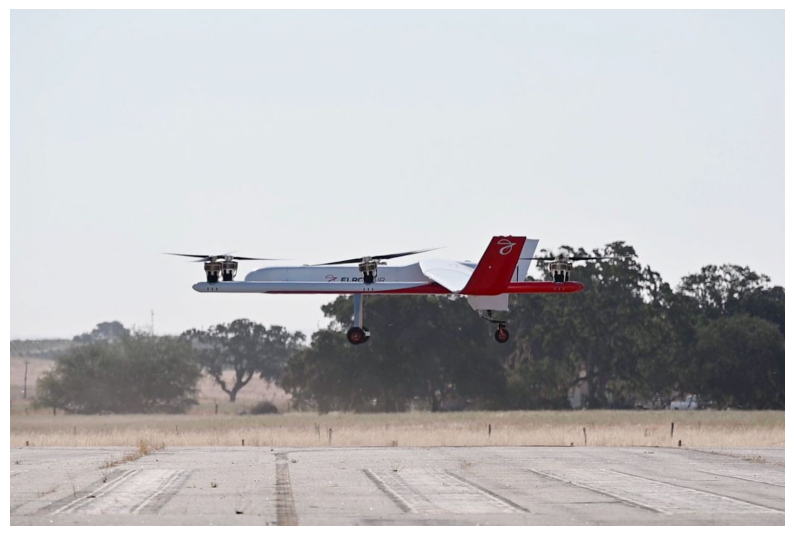

In [9]:
#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 380 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 779.5, 573.5, -0.5)

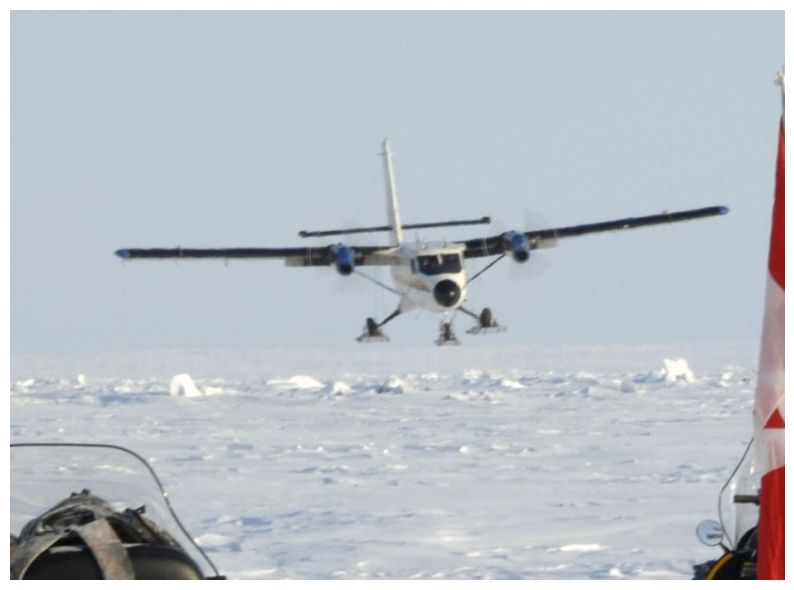

In [10]:
#@title Wybierz indeks przykładowego zdjęcia samolotu pasażerskiego ze zbioru treningowego:

idx = 699 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

# Augmentacja danych

In [11]:
"""👉WAŻNE👈"""
train_datagen = ImageDataGenerator(
    rotation_range=40,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)                           # generator można po nim iterować 👈👈👈👈

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')  # łądujemny bezpośrednio z katalogu
                                                                         # różne rozmiary zdjęć więc standaryzacja rozmiaru "target size"


# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)  # tlko przekształcenie do 0 - 1 wartości na zbiorze validacyjnym 👈👈👈👈


valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

Found 1838 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


In [12]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)] # generuje scieżki do plików 👈👈👈👈
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)  # przekształcanie do tablicy numpy
    print(x.shape)
    x = x.reshape((1, ) + x.shape) # dodawanie jednego wymiaru ✨✨✨✨✨✨✨✨
    print(x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for k in train_datagen.flow(x, batch_size=1):  # generator można po nim iterować 👈👈👈👈
        plt.subplot(3, 4, i)
        plt.grid(False)
        plt.imshow(image.array_to_img(k[0]))
        i += 1
        if i % 13 == 0:
            break

(150, 150, 3)
(1, 150, 150, 3)


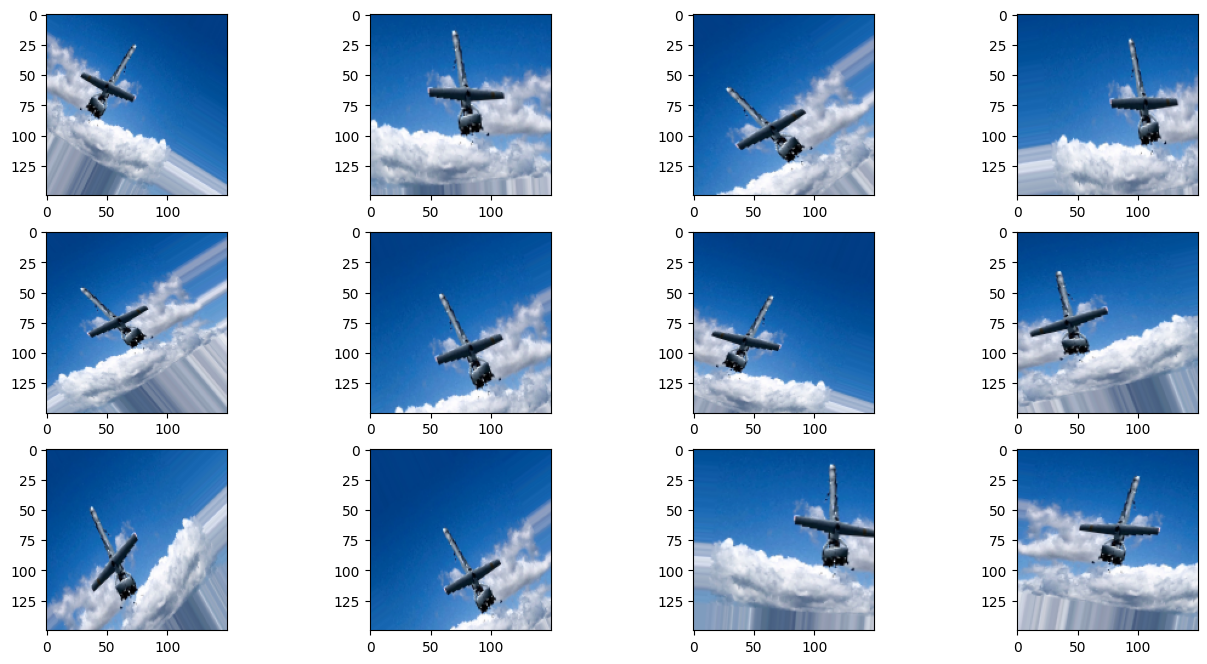

In [13]:
#@title Zbiór treningowy drone:
idx = 189 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_drone_dir, idx)

(150, 150, 3)
(1, 150, 150, 3)


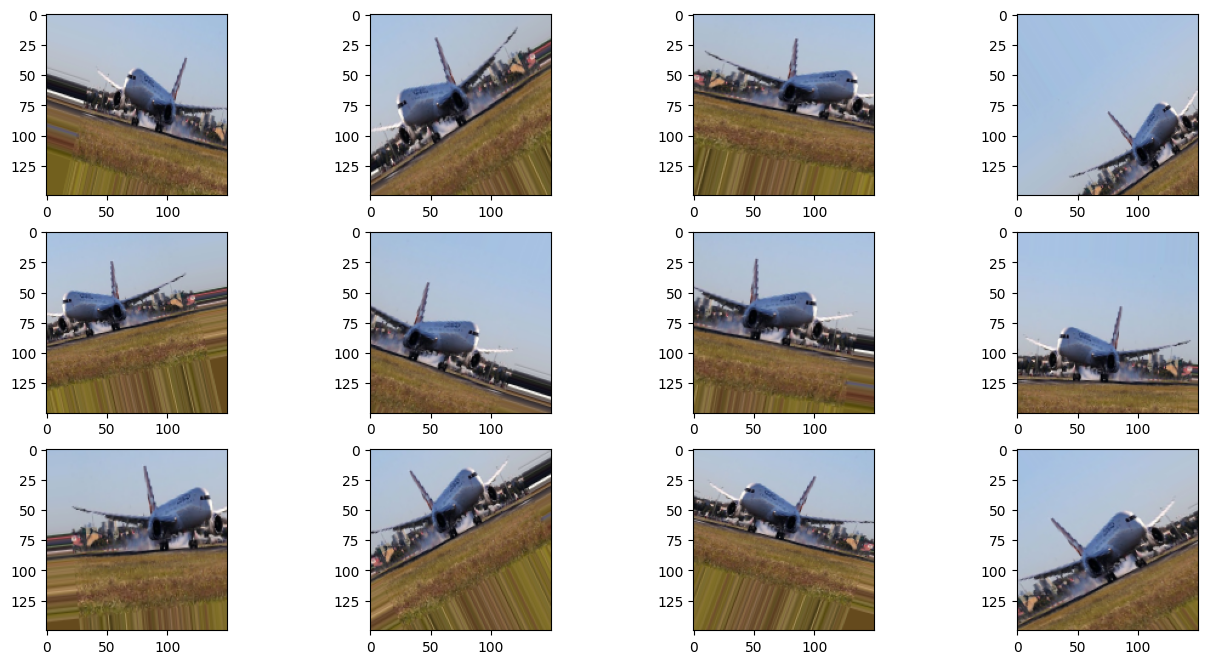

In [14]:
#@title Zbiór treningowy passenger:
idx = 111 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_passenger_dir, idx)

# Budowa modelu

In [15]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))  # operacja na obrazie -> kolor (150, 150, 3)👈 == 150+1-3, 150+1-3=148
model.add(layers.MaxPooling2D(pool_size=(2, 2)))                                                        # operacja na obrazie 148/ 2 = 74
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))                             # operacja na obrazie
model.add(layers.MaxPooling2D(pool_size=(2, 2)))                                                        # operacja na obrazie
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))                            # operacja na obrazie
model.add(layers.MaxPooling2D(pool_size=(2, 2)))                                                        # operacja na obrazie
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))                            # operacja na obrazie
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())                                         # tutaj dopiero wypłaszczenie tablicy do 1D 👈👈👈👈😶‍🌫️
model.add(layers.Dense(units=512, activation='relu'))               # sieć gęsto połączona
model.add(layers.Dense(units=1, activation='sigmoid'))              # sieć gęsto połączona
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [16]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [17]:
"""tworzymy katalog do generowania logów lub usówa jak już jest"""
!rm -rf logs
!mkdir logs

In [18]:
tensorboard = TensorBoard(log_dir='logs')

In [19]:
batch_size = 32  # rozmiar wsadu

steps_per_epoch = train_size // batch_size        # tak się określa ten parametr 👈
validation_steps = valid_size // batch_size       # tak się określa ten parametr 👈

history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,           # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])  # fit_generator z uwagi, że trenujemy generator 👉ImageDataGenerator👈

<ipython-input-19-f311991a4eeb>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/30
28/28 [==============================] - 74s 2s/step - loss: 0.7188 - accuracy: 0.4954 - val_loss: 0.6931 - val_accuracy: 0.4805
Epoch 2/30
28/28 [==============================] - 64s 2s/step - loss: 0.6913 - accuracy: 0.5156 - val_loss: 1.1772 - val_accuracy: 0.5078
Epoch 3/30
28/28 [==============================] - 72s 2s/step - loss: 0.6918 - accuracy: 0.5234 - val_loss: 0.6937 - val_accuracy: 0.4688
Epoch 4/30
28/28 [==============================] - 59s 2s/step - loss: 0.6931 - accuracy: 0.5357 - val_loss: 0.6899 - val_accuracy: 0.5625
Epoch 5/30
28/28 [==============================] - 65s 2s/step - loss: 0.6965 - accuracy: 0.5763 - val_loss: 0.6887 - val_accuracy: 0.5781
Epoch 6/30
28/28 [==============================] - 71s 2s/step - loss: 0.6847 - accuracy: 0.5752 - val_loss: 0.6893 - val_accuracy: 0.5469
Epoch 7/30
28/28 [==============================] - 63s 2s/step - loss: 0.6835 - accuracy: 0.5603 - val_loss: 0.6696 - val_accuracy: 0.5781
Epoch 8/30
28/28 [==

In [20]:
%load_ext tensorboard

In [21]:
!tensorboard dev upload --logdir logs

2024-06-29 19:31:29.072990: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 19:31:29.073065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 19:31:29.075079: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-29 19:31:31.117407: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb

In [22]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

# Transfer learning -----> model VGG16

In [23]:
from tensorflow.keras.applications import VGG16

https://keras.io/api/applications/

In [24]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))  # trenowany na dużej ilości danych
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [25]:
model = Sequential()
model.add(conv_base)                                    # transfer learning 👈
model.add(layers.Flatten())                             # wypłaszczenie danych
model.add(layers.Dense(units=256, activation='relu'))   # siatka gęsto połączona
model.add(layers.Dense(units=1, activation='sigmoid'))   # problem binarny acivation ==> sigmoid
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#👉👉👉👉Zamrażanie warstw "conv_base" z transer learningu - tak aby nasz model od nowa ich nie trenował 👈👈👈👈

In [26]:
print(f'Liczba warstw trenowanych przed zamrożeniem {len(model.trainable_weights)}')

conv_base.trainable = False          # 👈👈👈👈👈👈👈✨ !!!!!!!!!!!!!!!!!!!!!

print(f'Liczba warstw trenowanych po zamrożeniu {len(model.trainable_weights)}')

Liczba warstw trenowanych przed zamrożeniem 30
Liczba warstw trenowanych po zamrożeniu 4


In [27]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),   # optimizers.RMSprop(learning_rate=0.001)
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [28]:
history = model.fit_generator(generator=train_generator,                            # samo model.fit() też już obsługuje generatory 👈✨
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

<ipython-input-28-2bf025e50aaf>:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
28/28 [==============================] - 302s 11s/step - loss: 1.1117 - accuracy: 0.5979 - val_loss: 0.5110 - val_accuracy: 0.7070
Epoch 2/30
28/28 [==============================] - 306s 11s/step - loss: 0.6411 - accuracy: 0.6618 - val_loss: 0.4671 - val_accuracy: 0.7891
Epoch 3/30
28/28 [==============================] - 304s 11s/step - loss: 0.5362 - accuracy: 0.7321 - val_loss: 0.7689 - val_accuracy: 0.6289
Epoch 4/30
28/28 [==============================] - 304s 11s/step - loss: 0.5578 - accuracy: 0.7266 - val_loss: 0.4929 - val_accuracy: 0.7422
Epoch 5/30
28/28 [==============================] - 299s 11s/step - loss: 0.5039 - accuracy: 0.7358 - val_loss: 0.5592 - val_accuracy: 0.7109
Epoch 6/30
28/28 [==============================] - 279s 10s/step - loss: 0.4921 - accuracy: 0.7449 - val_loss: 0.4440 - val_accuracy: 0.7695
Epoch 7/30
28/28 [==============================] - 305s 11s/step - loss: 0.5158 - accuracy: 0.7489 - val_loss: 0.3941 - val_accuracy: 0.8203
Epoch 

In [29]:
import plotly.graph_objects as go
plot_hist(history)

# Transfer learning - model VGG16 - odmrożenie ostatnich warstw

In [30]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base)

layer_name: input_2       trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


In [31]:
"""👉WAŻNE👈"""
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_2       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


In [32]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 9177089 (35.01 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [33]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=20,
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

<ipython-input-33-e2a6d919a5d8>:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/20
28/28 [==============================] - 337s 12s/step - loss: 14.1978 - accuracy: 0.5167 - val_loss: 0.6923 - val_accuracy: 0.5312
Epoch 2/20
28/28 [==============================] - 330s 12s/step - loss: 0.6937 - accuracy: 0.4875 - val_loss: 0.6934 - val_accuracy: 0.4805
Epoch 3/20
28/28 [==============================] - 329s 12s/step - loss: 0.6932 - accuracy: 0.5103 - val_loss: 0.6926 - val_accuracy: 0.5273
Epoch 4/20
28/28 [==============================] - 330s 12s/step - loss: 0.6935 - accuracy: 0.4795 - val_loss: 0.6932 - val_accuracy: 0.4766
Epoch 5/20
28/28 [==============================] - 334s 12s/step - loss: 0.6932 - accuracy: 0.4766 - val_loss: 0.6931 - val_accuracy: 0.5156
Epoch 6/20
28/28 [==============================] - 332s 12s/step - loss: 0.6932 - accuracy: 0.5067 - val_loss: 0.6932 - val_accuracy: 0.4727
Epoch 7/20
28/28 [==============================] - 308s 11s/step - loss: 0.6930 - accuracy: 0.5228 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch

# Ocena modelu

In [34]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='binary',
    shuffle=False   # 👈 bez tasownaia danych
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob = y_prob.ravel()
y_prob

Found 262 images belonging to 2 classes.


<ipython-input-34-7c971a2c9b8e>:10: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



array([0.500874, 0.500874, 0.500874, 0.500874, 0.500874, 0.500874,
       0.500874, 0.500874, 0.500874, 0.500874, 0.500874, 0.500874,
       0.500874, 0.500874, 0.500874, 0.500874, 0.500874, 0.500874,
       0.500874, 0.500874, 0.500874, 0.500874, 0.500874, 0.500874,
       0.500874, 0.500874, 0.500874, 0.500874, 0.500874, 0.500874,
       0.500874, 0.500874, 0.500874, 0.500874, 0.500874, 0.500874,
       0.500874, 0.500874, 0.500874, 0.500874, 0.500874, 0.500874,
       0.500874, 0.500874, 0.500874, 0.500874, 0.500874, 0.500874,
       0.500874, 0.500874, 0.500874, 0.500874, 0.500874, 0.500874,
       0.500874, 0.500874, 0.500874, 0.500874, 0.500874, 0.500874,
       0.500874, 0.500874, 0.500874, 0.500874, 0.500874, 0.500874,
       0.500874, 0.500874, 0.500874, 0.500874, 0.500874, 0.500874,
       0.500874, 0.500874, 0.500874, 0.500874, 0.500874, 0.500874,
       0.500874, 0.500874, 0.500874, 0.500874, 0.500874, 0.500874,
       0.500874, 0.500874, 0.500874, 0.500874, 0.500874, 0.500

In [35]:
predictions  = pd.DataFrame({'y_prob': y_prob})
predictions['class'] = predictions['y_prob'].apply(lambda x: 1 if x > 0.5 else 0)
predictions

,y_prob,class
0,0.500874,1
1,0.500874,1
2,0.500874,1
3,0.500874,1
4,0.500874,1
...,...,...
257,0.500874,1
258,0.500874,1
259,0.500874,1
260,0.500874,1


In [36]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [37]:
y_pred = predictions['class'].values
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [38]:

test_generator.class_indices

{'drone': 0, 'passenger': 1}

In [39]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[  0, 131],
       [  0, 131]])

In [40]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       131
           1       0.50      1.00      0.67       131

    accuracy                           0.50       262
   macro avg       0.25      0.50      0.33       262
weighted avg       0.25      0.50      0.33       262



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# Wyświetlanie błędów

In [41]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors.head()

,y_true,y_pred
drone/00000009.jpg,0,1
drone/00000029.jpg,0,1
drone/00000033.jpg,0,1
drone/00000044.jpg,0,1
drone/00000060.jpg,0,1


In [42]:
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

,y_true,y_pred,is_incorrect
drone/00000009.jpg,0,1,1
drone/00000029.jpg,0,1,1
drone/00000033.jpg,0,1,1
drone/00000044.jpg,0,1,1
drone/00000060.jpg,0,1,1
...,...,...,...
passenger/00001446.jpg,1,1,0
passenger/00001451.jpg,1,1,0
passenger/00001469.jpg,1,1,0
passenger/00001472.jpg,1,1,0


In [43]:
errors[errors['is_incorrect'] == 1].index

Index(['drone/00000009.jpg', 'drone/00000029.jpg', 'drone/00000033.jpg',
       'drone/00000044.jpg', 'drone/00000060.jpg', 'drone/00000071.jpg',
       'drone/00000074.jpg', 'drone/00000097.jpg', 'drone/00000108.jpg',
       'drone/00000139.jpg',
       ...
       'drone/00001333.jpg', 'drone/00001337.JPG', 'drone/00001349.jpg',
       'drone/00001364.jpg', 'drone/00001368.png', 'drone/00001374.jpg',
       'drone/00001378.jpg', 'drone/00001383.jpg', 'drone/00001389.jpg',
       'drone/00001400.jpg'],
      dtype='object', length=131)

# przeglądanie niepoprawnych przypisań
* drone
* passanger

In [1]:
# img_path = os.path.join(test_drone_dir, '00000009..JPG')  # 👈👈 ręczna zmiana nazyw pliku

# img = image.load_img(img_path)

# plt.figure(figsize=(10, 10))
# plt.imshow(img)
# plt.grid(False)
# plt.axis(False)

In [ ]:
errors[errors['is_incorrect'] == 1].index

In [ ]:
# img_path = os.path.join(test_passenger_dir, '00001453.jpg')   # 👈👈 ręczna zmiana nazyw pliku

# img = image.load_img(img_path)

# plt.figure(figsize=(10, 10))
# plt.imshow(img)
# plt.grid(False)
# plt.axis(False)